1. Preprocessing  
2. First models evaluation  
3. Handle Class imbalance  
4. Threshold adjustment  
5. Hyperparameter tuning  
6. Best model selection  
7. Final evaluation on Test set

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, precision_recall_curve, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

from scipy.stats import randint
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv('../data/dataset_ready.csv')

In [ ]:
# year_avgscore = data.groupby('release_year')['score'].mean()
# data['competition'] = data['release_year'].map(year_avgscore)

In [ ]:
# from sklearn.decomposition import PCA

# correlated_features = data[['popularity', 'followers_log']]

# pca = PCA(n_components=1)  # Reduce to 1 component
# data['popularity_followers_pca'] = pca.fit_transform(correlated_features)

# data = data.drop(['popularity', 'followers_log'], axis=1)

## 1. Preprocessing

In [ ]:
# Split the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [ ]:
# Separate features and target
X_train = df_train.drop(columns=['song_id', 'hit'])
y_train = df_train['hit']
X_val = df_val.drop(columns=['song_id', 'hit'])
y_val = df_val['hit']
X_test = df_test.drop(columns=['song_id', 'hit'])
y_test = df_test['hit']

In [ ]:
# Define preprocessing steps (standard scaling and one-hot encoding)
numerical = ['release_year', 'duration_log', 'popularity', 'followers_log', 'acousticness', 'liveness', 'speechiness', 
            'instrumentalness', 'loudness', 'energy', 'danceability', 'valence', 'tempo']
categorical = ['key', 'artist_type', 'genre']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

## 2. First models evaluation

In [8]:
# Define models with default parameters
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Train each model and store it
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

In [9]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    return {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba)
    }

# Collect evaluation results
validation_results = {}
for name, model in trained_models.items():
    validation_results[name] = evaluate_model(model, X_val, y_val)

# Print validation results
pd.DataFrame(validation_results).T

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.698113,0.581019,0.192780,0.289504,0.705054
Random Forest,0.714776,0.627306,0.261137,0.368764,0.724028
Gradient Boosting,0.709875,0.609259,0.252688,0.357220,0.724876
XGBoost,0.699338,0.542759,0.365591,0.436898,0.699702


The accuracy is around 70%, but this metric is misleading due to the class imbalance. Since the dataset is dominated by "non-hit" songs, models can achieve high accuracy by mostly predicting "non-hit" (i.e., the majority class).  
Accuracy is not informative in imbalanced classification problems. Focus on metrics like Precision, Recall, F1-score, and ROC-AUC for model evaluation. F1-score and ROC-AUC are particularly useful in assessing model performance on the minority class.

A small Precision and Recall mean that even when the model identifies a song as a "hit," it’s either incorrect (low precision) or it rarely identifies true hits (low recall).

## 3. Handle Class imbalance

In [13]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define models with class weights
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    print(f"{name}:")
    print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
    print(classification_report(y_val, y_val_pred, target_names=["Non-Hit", "Hit"]))
    print("\n")

Logistic Regression:
ROC AUC: 0.7046028779595043
              precision    recall  f1-score   support

     Non-Hit       0.81      0.61      0.70      2779
         Hit       0.45      0.70      0.55      1302

    accuracy                           0.64      4081
   macro avg       0.63      0.65      0.62      4081
weighted avg       0.70      0.64      0.65      4081



Random Forest:
ROC AUC: 0.7194299024558226
              precision    recall  f1-score   support

     Non-Hit       0.76      0.80      0.78      2779
         Hit       0.53      0.47      0.50      1302

    accuracy                           0.70      4081
   macro avg       0.65      0.64      0.64      4081
weighted avg       0.69      0.70      0.69      4081



Gradient Boosting:
ROC AUC: 0.7126904714920825
              precision    recall  f1-score   support

     Non-Hit       0.78      0.73      0.75      2779
         Hit       0.49      0.57      0.53      1302

    accuracy                           

## 4. Threshold adjustment

For some models, the default classification threshold (0.5) may not work well with imbalanced data. Consider adjusting the threshold to improve recall and precision for the "hit" class.

In [14]:
thresholds = [i / 10 for i in range(1, 10)]

def evaluate_thresholds(y_true, y_scores, thresholds):
    results = []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append({'Threshold': t, 'Precision': precision, 'Recall': recall, 'F1': f1})
    return results

threshold_results = {}
for model_name, model in models.items():
    y_scores = model.predict_proba(X_val)[:, 1]
    threshold_results[model_name] = evaluate_thresholds(y_val, y_scores, thresholds)

for model_name, results in threshold_results.items():
    print(f"Model: {model_name}")
    print(pd.DataFrame(results))

c:\Users\marti.MARTIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti.MARTIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marti.MARTIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Model: Logistic Regression
   Threshold  Precision    Recall        F1
0        0.1   0.320364  0.999232  0.485176
1        0.2   0.337523  0.990015  0.503417
2        0.3   0.362110  0.943932  0.523424
3        0.4   0.395886  0.842550  0.538669
4        0.5   0.454955  0.698157  0.550909
5        0.6   0.530357  0.456221  0.490504
6        0.7   0.595588  0.186636  0.284211
7        0.8   0.673913  0.023810  0.045994
8        0.9   0.000000  0.000000  0.000000
Model: Random Forest
   Threshold  Precision    Recall        F1
0        0.1   0.328590  0.993088  0.493794
1        0.2   0.361408  0.962366  0.525477
2        0.3   0.400771  0.877880  0.550313
3        0.4   0.456004  0.720430  0.558500
4        0.5   0.519491  0.501536  0.510356
5        0.6   0.602170  0.255760  0.359030
6        0.7   0.673797  0.096774  0.169241
7        0.8   0.774194  0.018433  0.036009
8        0.9   1.000000  0.001536  0.003067
Model: Gradient Boosting
   Threshold  Precision    Recall        F1
0  

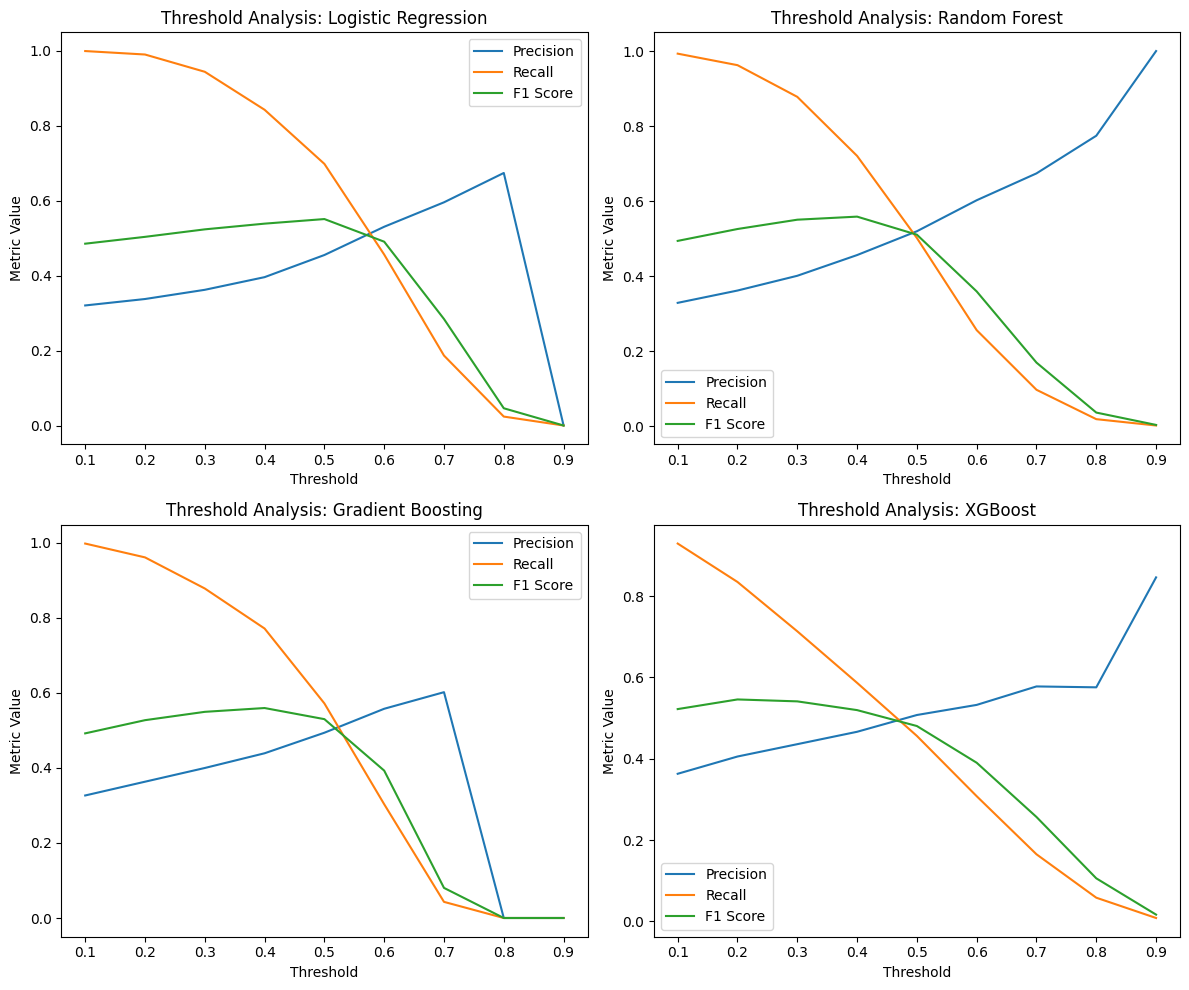

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model_name, results) in enumerate(threshold_results.items()):
    results_df = pd.DataFrame(results)
    ax = axes[i]
    ax.plot(results_df['Threshold'], results_df['Precision'], label='Precision')
    ax.plot(results_df['Threshold'], results_df['Recall'], label='Recall')
    ax.plot(results_df['Threshold'], results_df['F1'], label='F1 Score')
    ax.set_title(f"Threshold Analysis: {model_name}")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Metric Value")
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
# Function to evaluate thresholds for precision-recall
def best_thresholds(y_val, y_scores):
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)  # To avoid division by zero
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    
    return {
        "Best Threshold": best_threshold,
        "Precision": precisions[best_threshold_index],
        "Recall": recalls[best_threshold_index],
        "F1 Score": f1_scores[best_threshold_index]
    }

# Store results for each model
threshold_results = {}

for name, model in models.items():
    # Predict probabilities for the positive class
    y_scores = model.predict_proba(X_val)[:, 1]
    
    # Evaluate thresholds
    results = best_thresholds(y_val, y_scores)
    threshold_results[name] = results

# Display results
for model_name, result in threshold_results.items():
    print(f"{model_name}:")
    print(f"  Best Threshold: {result['Best Threshold']}")
    print(f"  Precision: {result['Precision']:.4f}")
    print(f"  Recall: {result['Recall']:.4f}")
    print(f"  F1 Score: {result['F1 Score']:.4f}")

Logistic Regression:
  Best Threshold: 0.48136883391371793
  Precision: 0.4440
  Recall: 0.7373
  F1 Score: 0.5543
Random Forest:
  Best Threshold: 0.37
  Precision: 0.4429
  Recall: 0.7773
  F1 Score: 0.5643
Gradient Boosting:
  Best Threshold: 0.38496669268015277
  Precision: 0.4352
  Recall: 0.7942
  F1 Score: 0.5623
XGBoost:
  Best Threshold: 0.26357054710388184
  Precision: 0.4283
  Recall: 0.7588
  F1 Score: 0.5475


**Re-evalute models with adjusted threshold:**

In [17]:
thresholds = {
    'Logistic Regression': 0.48,
    'Random Forest': 0.37,
    'Gradient Boosting': 0.38,
    'XGBoost': 0.26
}

results = {}
for name, model in models.items():
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_val_adjusted = (y_val_proba >= thresholds[name]).astype(int)
    
    roc_auc = roc_auc_score(y_val, y_val_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted, average='binary')
    classification_rep = classification_report(y_val, y_val_adjusted, target_names=["Non-Hit", "Hit"])
    
    results[name] = {
        'Threshold': thresholds[name],
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Classification Report': classification_rep
    }

for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"Threshold: {metrics['Threshold']}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("-" * 50)

Model: Logistic Regression
Threshold: 0.48
ROC AUC: 0.7046
Precision: 0.4427
Recall: 0.7381
F1-Score: 0.5534
Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.82      0.56      0.67      2779
         Hit       0.44      0.74      0.55      1302

    accuracy                           0.62      4081
   macro avg       0.63      0.65      0.61      4081
weighted avg       0.70      0.62      0.63      4081

--------------------------------------------------
Model: Random Forest
Threshold: 0.37
ROC AUC: 0.7194
Precision: 0.4429
Recall: 0.7773
F1-Score: 0.5643
Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.84      0.54      0.66      2779
         Hit       0.44      0.78      0.56      1302

    accuracy                           0.62      4081
   macro avg       0.64      0.66      0.61      4081
weighted avg       0.71      0.62      0.63      4081

-------------------------------------

## 5. Hyperparameter tuning

for Random Forest and Gradient Boosting models

In [ ]:
# Custom scorer to calculate F1 and ROC-AUC with an adjustable threshold
def combined_scorer_with_threshold(y_true, y_scores, threshold):
    y_pred = (y_scores > threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    return 0.5 * f1 + 0.5 * roc_auc

# Wrapper for scorer to pass the threshold dynamically
def scorer(estimator, X, y):
    # Use the model-specific threshold for prediction
    threshold = estimator.threshold
    y_scores = estimator.base_model.predict_proba(X)[:, 1]
    return combined_scorer_with_threshold(y, y_scores, threshold)

In [19]:
class ThresholdClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict(self, X):
        y_scores = self.base_model.predict_proba(X)[:, 1]
        return (y_scores > self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

In [ ]:
# Hyperparameter grids with fixed thresholds (based on earlier analysis)
rf_param_grid = {
    'base_model__n_estimators': randint(100, 1000),
    'base_model__max_depth': [None] + list(range(5, 50, 5)),
    'base_model__min_samples_split': randint(2, 10),
    'base_model__min_samples_leaf': randint(1, 10),
    'base_model__max_features': ['sqrt', 'log2', None]
}

gb_param_grid = {
    'base_model__n_estimators': randint(100, 1000),
    'base_model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'base_model__max_depth': list(range(3, 20, 2)),
    'base_model__min_samples_split': randint(2, 10),
    'base_model__min_samples_leaf': randint(1, 10),
    'base_model__subsample': [0.6, 0.8, 1.0]
}

In [ ]:
# Models with optimal thresholds
models_to_tune = {
    'Random Forest': (ThresholdClassifierWrapper(RandomForestClassifier(class_weight='balanced', random_state=42), threshold=0.37), rf_param_grid),
    'Gradient Boosting': (ThresholdClassifierWrapper(GradientBoostingClassifier(random_state=42), threshold=0.38), gb_param_grid)
}

# Results dictionary
tuned_models = {}

for model_name, (model, param_grid) in models_to_tune.items():
    print(f"Tuning {model_name}...")
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=50,
        scoring=scorer,  # Use the updated dynamic scorer
        n_jobs=-1,
        cv=3,
        random_state=42,
        verbose=2
    )
    
    # Fit the model
    random_search.fit(X_train_resampled, y_train_resampled)
    
    # Save the best model and its parameters
    tuned_models[model_name] = {
        'Best Estimator': random_search.best_estimator_,
        'Best Parameters': random_search.best_params_,
        'Best Score': random_search.best_score_
    }

# Display results
for model_name, results in tuned_models.items():
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {results['Best Parameters']}")
    print(f"Best Score: {results['Best Score']:.4f}")

Tuning Random Forest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Tuning Gradient Boosting...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Model: Random Forest
Best Parameters: {'base_model__max_depth': 30, 'base_model__max_features': 'log2', 'base_model__min_samples_leaf': 1, 'base_model__min_samples_split': 2, 'base_model__n_estimators': 476}
Best Score: 0.8203

Model: Gradient Boosting
Best Parameters: {'base_model__learning_rate': 0.1, 'base_model__max_depth': 17, 'base_model__min_samples_leaf': 1, 'base_model__min_samples_split': 4, 'base_model__n_estimators': 572, 'base_model__subsample': 0.8}
Best Score: 0.8204


## 6. Best model selection

In [43]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [50]:
best_rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=476, class_weight='balanced')
best_rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = best_rf.predict(X_val)
y_proba_rf = best_rf.predict_proba(X_val)[:, 1]
y_val_adjusted_rf = (y_proba_rf >= 0.37).astype(int)

In [51]:
roc_auc = roc_auc_score(y_val, y_proba_rf)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted_rf, average='binary')
classification_rep = classification_report(y_val, y_val_adjusted_rf, target_names=["Non-Hit", "Hit"])
    
results = {
    'ROC AUC': roc_auc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Classification Report': classification_rep
}

for name, metrics in results.items():
    if name == "Classification Report":
        print(f"{name}:")
        print(metrics)
    else:
        print(f"{name}: {metrics:.4f}")
    print("-" * 50)

ROC AUC: 0.7202
--------------------------------------------------
Precision: 0.4374
--------------------------------------------------
Recall: 0.7803
--------------------------------------------------
F1-Score: 0.5606
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.84      0.53      0.65      2779
         Hit       0.44      0.78      0.56      1302

    accuracy                           0.61      4081
   macro avg       0.64      0.66      0.60      4081
weighted avg       0.71      0.61      0.62      4081

--------------------------------------------------


In [52]:
best_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=17, min_samples_leaf=1, min_samples_split=4, n_estimators=572, subsample=0.8)
best_gb.fit(X_train_resampled, y_train_resampled)

y_pred_gb = best_gb.predict(X_val)
y_proba_gb = best_gb.predict_proba(X_val)[:, 1]
y_val_adjusted_gb = (y_proba_gb >= 0.38).astype(int)

In [58]:
roc_auc = roc_auc_score(y_val, y_proba_gb)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_adjusted_gb, average='binary')
classification_rep = classification_report(y_val, y_val_adjusted_gb, target_names=["Non-Hit", "Hit"])
    
results = {
    'ROC AUC': roc_auc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Classification Report': classification_rep
}

for name, metrics in results.items():
    if name == "Classification Report":
        print(f"{name}:")
        print(metrics)
    else:
        print(f"{name}: {metrics:.4f}")
    print("-" * 50)

ROC AUC: 0.7150
--------------------------------------------------
Precision: 0.5372
--------------------------------------------------
Recall: 0.4378
--------------------------------------------------
F1-Score: 0.4824
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.76      0.82      0.79      2779
         Hit       0.54      0.44      0.48      1302

    accuracy                           0.70      4081
   macro avg       0.65      0.63      0.64      4081
weighted avg       0.69      0.70      0.69      4081

--------------------------------------------------


* Random Forest has better recall for the minority class (class 1), making it more useful for situations where minimizing false negatives is critical.
* Gradient Boosting performs better in terms of precision for class 1 and overall accuracy but sacrifices recall for the minority class.

## 7. Final evaluation on Test set

In [59]:
X_full_train = df_full_train.drop(columns=['song_id', 'hit'])
y_full_train = df_full_train['hit']

X_full_train = preprocessor.fit_transform(X_full_train)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_full_train, y_full_train)

In [ ]:
# Random Forest
best_rf.fit(X_train_resampled, y_train_resampled)
rf_pred_proba = best_rf.predict_proba(X_test)[:, 1]
rf_pred = (rf_pred_proba > 0.37).astype(int)
print("Random Forest Metrics:")
print(classification_report(y_test, rf_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")

# Gradient Boosting
best_gb.fit(X_train_resampled, y_train_resampled)
gb_pred_proba = best_gb.predict_proba(X_test)[:, 1]
gb_pred = (gb_pred_proba > 0.38).astype(int)
print("\nGradient Boosting Metrics:")
print(classification_report(y_test, gb_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, gb_pred_proba):.4f}")

Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.83      0.54      0.66      2806
           1       0.43      0.75      0.55      1275

    accuracy                           0.61      4081
   macro avg       0.63      0.65      0.60      4081
weighted avg       0.70      0.61      0.62      4081

ROC-AUC: 0.7067

Gradient Boosting Metrics:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2806
           1       0.50      0.48      0.49      1275

    accuracy                           0.69      4081
   macro avg       0.64      0.63      0.63      4081
weighted avg       0.69      0.69      0.69      4081

ROC-AUC: 0.6984


**Model Selection:**

I will finally choose the Random Forest model as it's way faster to compute and has a slightly better ROC-AUC of 72%